# IST-781 Lab 09
## Leonard Armstrong


---

This file contains the PyTorch implementation of a CNN to reognize the Fashion-MNIST data set.

# Determine Environment

Before starting any real processing, let's take a look at the environment in which we are operating.

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: G

In [2]:
!nvidia-smi

Sat Jun  8 17:29:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.9 GB  | Proc size: 120.9 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


# LIBRARY IMPORTS SECTION

In [4]:
#--------------------------------------------------------------------------------------------------
# ENABLE COLAB DRIVES

# Mount Google drive into Colab environment.
from google.colab import drive
drive.mount('/content/gdrive')

#--------------------------------------------------------------------------------------------------
# LOAD LIBRARIES

# Plotting and graphics
import matplotlib        as mpl
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
#import torchvision.datasets as dsets

from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Constant Definitions

In [5]:
#--------------------------------------------------------------------------------------------------
# CONSTANT DEFINITIONS

# File locations
TRAINDATA_FPATH = 'gdrive/My Drive/Colab Notebooks/fashionmnist/fashion-mnist_train.csv'
TESTDATA_FPATH  = 'gdrive/My Drive/Colab Notebooks/fashionmnist/fashion-mnist_test.csv'


NUM_EPOCHS = 9;
BATCH_SIZE = 75;
LEARNING_RATE = 0.003;

LABELS_MAP = {
    0 : 'T-Shirt', 
    1 : 'Trouser', 
    2 : 'Pullover', 
    3 : 'Dress', 
    4 : 'Coat', 
    5 : 'Sandal', 
    6 : 'Shirt',
    7 : 'Sneaker', 
    8 : 'Bag', 
    9 : 'Ankle Boot'};

# Define the random seed
torch.manual_seed(0)

# Class Definitions

In [0]:
class FashionMNISTDataset(torch.utils.data.Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);

# Load Data

In [7]:
#--------------------------------------------------------------------------------------------------
# Load training and test data sets

%%time

train_dataset = FashionMNISTDataset(csv_file=TRAINDATA_FPATH)
test_dataset = FashionMNISTDataset(csv_file=TESTDATA_FPATH)

CPU times: user 5.68 s, sys: 858 ms, total: 6.53 s
Wall time: 6.63 s


In [0]:
# Define the PyTorch data loaders

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True);
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True);

## NEXT BLOCK OF CODE NEEDS TO BE REPLACED
### OR REMOVED

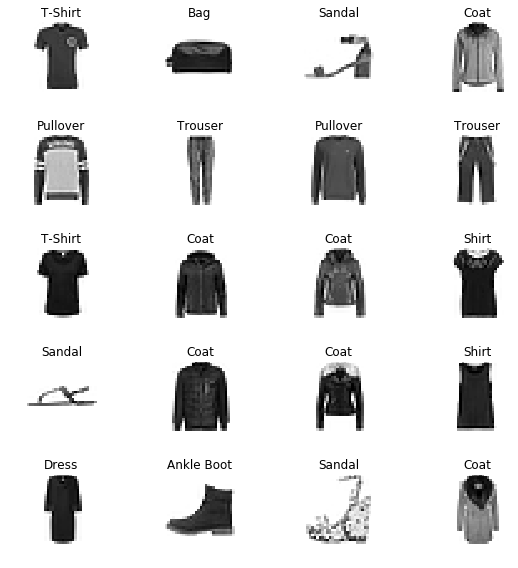

In [9]:
## Replace this with same code from the non-PyTorch version

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(LABELS_MAP[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap=mpl.cm.binary)
plt.tight_layout()
plt.show()

# Define the Neural Network

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
#instance of the Conv Net
cnn = CNN();

#loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE);

In [12]:
%%time

losses = [];
for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):

        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, NUM_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data))

Epoch : 1/9, Iter : 100/800,  Loss: 0.7281
Epoch : 1/9, Iter : 200/800,  Loss: 0.3433
Epoch : 1/9, Iter : 300/800,  Loss: 0.2674
Epoch : 1/9, Iter : 400/800,  Loss: 0.3274
Epoch : 1/9, Iter : 500/800,  Loss: 0.3107
Epoch : 1/9, Iter : 600/800,  Loss: 0.2234
Epoch : 1/9, Iter : 700/800,  Loss: 0.2945
Epoch : 1/9, Iter : 800/800,  Loss: 0.3257
Epoch : 2/9, Iter : 100/800,  Loss: 0.3637
Epoch : 2/9, Iter : 200/800,  Loss: 0.3911
Epoch : 2/9, Iter : 300/800,  Loss: 0.1731
Epoch : 2/9, Iter : 400/800,  Loss: 0.2556
Epoch : 2/9, Iter : 500/800,  Loss: 0.2331
Epoch : 2/9, Iter : 600/800,  Loss: 0.2485
Epoch : 2/9, Iter : 700/800,  Loss: 0.2124
Epoch : 2/9, Iter : 800/800,  Loss: 0.2796
Epoch : 3/9, Iter : 100/800,  Loss: 0.2470
Epoch : 3/9, Iter : 200/800,  Loss: 0.2075
Epoch : 3/9, Iter : 300/800,  Loss: 0.1927
Epoch : 3/9, Iter : 400/800,  Loss: 0.2816
Epoch : 3/9, Iter : 500/800,  Loss: 0.2758
Epoch : 3/9, Iter : 600/800,  Loss: 0.2099
Epoch : 3/9, Iter : 700/800,  Loss: 0.3382
Epoch : 3/9

In [13]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    test_accuracy = (100.0*float(correct))/float(total)

print('Test Accuracy of the model on the 10000 test images: %.2f %%' % test_accuracy)

Test Accuracy of the model on the 10000 test images: 91.54 %


In [14]:
cnn.eval()
correct = 0
total = 0
for images, labels in train_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    train_accuracy = (100.0*float(correct))/float(total)

print('Training Accuracy of the model on the 60000 train images: %.2f %%' % train_accuracy)

Training Accuracy of the model on the 60000 train images: 95.13 %


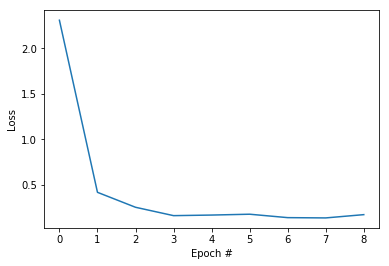

In [15]:
losses_in_epochs = losses[0::len(train_dataset)//BATCH_SIZE]
plt.figure()
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();

### Results

|Epochs|Batch Size|Learning Rate|Train %        |Test%  |
|------------|-----------------|----------------------|------------------|------------|
|15         |100            |0.005               |96.11%      |91.28%|
|6           |100            |0.005               |94.1633% |92.0600%|
|6           |50              |0.005               |92.8850%|90.5900%|
|             |                   |                         |93.60%    |91.36%|
|            |                    |                         |93.40%    |90.97%|
|6           |150            |0.005               |93.2750%|90.7600%|
|6           |75              |0.005               |92.4176%|90.5900%|
|6           |60              |0.005               |92.64%|90.13%|
|6           |60              |0.008               |93.39|91.20|
|5           |60              |0.008               |92.90|91.15|
|9           |75              |0.003               |95.13|91.54|

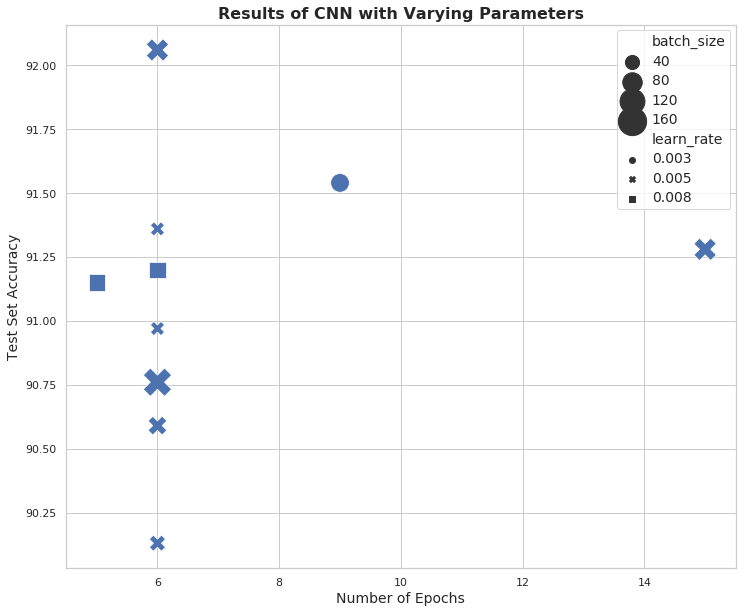

In [20]:

epochs =     [   15,     6,     6,     6,     6,     6,     6,     6,     6,     5,     9]
batch_size = [  100,   100,    50,    50,    50,   150,    75,    60,    60,    60,    75]
learn_rate = [0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.008, 0.008, 0.003]
train_acc  = [96.11, 94.16, 92.89, 93.60, 93.40, 93.28, 92.42, 92.64, 93.39, 92.90, 95.13]
test_acc   = [91.28, 92.06, 90.59, 91.36, 90.97, 90.76, 90.59, 90.13, 91.20, 91.15, 91.54]


df = pd.DataFrame({
    'epochs': epochs,
    'batch_size': batch_size,
    'learn_rate': learn_rate, 
    'train_accuracy': train_acc,
    'test_accuracy': test_acc})


import seaborn as sns;

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize = (12,10))
g = sns.scatterplot(
    ax=ax, 
    y=df.test_accuracy, x=df.epochs,
    size=df.batch_size, sizes=(200, 800),
    style=df.learn_rate)
plt.title('Results of CNN with Varying Parameters', fontsize=16, fontweight='bold')
plt.ylabel('Test Set Accuracy', fontsize=14)
plt.xlabel('Number of Epochs', fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.show()